<a href="https://colab.research.google.com/github/ankit-kothari/Data-Science-Journey/blob/transformers_lp_course/airline_tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install transformers 
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv
!pip install dask
!pip install 'fsspec>=0.3.3'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.0 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
     |████████████████████████████████| 6.6 MB 45.5 MB/s 
     |████████████████████████████████| 596 kB 59.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
--2022-06-05 22:57:04--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  15.2MB/s    in 0.2s    

2022-06-05 22:57:05 (15.2 MB/s) - ‘AirlineTweets.

In [6]:
!pip install datasets
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 7.8 MB/s 
     |████████████████████████████████| 212 kB 68.6 MB/s 
     |████████████████████████████████| 86 kB 7.0 MB/s 
     |████████████████████████████████| 1.1 MB 55.8 MB/s 
     |████████████████████████████████| 127 kB 52.2 MB/s 
     |████████████████████████████████| 144 kB 57.9 MB/s 
     |████████████████████████████████| 271 kB 50.6 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 112 kB 14.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.5.1
    Uninstalling dill-0.3.5.1:
      Successfully uninstalled dill-0.3.5.1
  Attempting uninstall: multiprocess
    Found existing installation: multi

In [7]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun  5 22:57:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
from transformers import pipeline
import torch
import spacy
import tqdm as notebook_tqdm
from torchinfo import summary
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,roc_auc_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import  matplotlib.pyplot as plt
from datasets import load_dataset
from spacy.lang.en import English
import warnings
from tqdm import tqdm
import re
import string
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import concurrent.futures
import dask.bag as db
import dask 
import graphviz
from dask import visualize

In [9]:
data = pd.read_csv('./AirlineTweets.csv')
data.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


In [10]:
data['text'].iloc[0:10]

0                                                                                                         @VirginAmerica What @dhepburn said.
1                                                                    @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                                     @VirginAmerica I didn't today... Must mean I need to take another trip!
3              @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                                     @VirginAmerica and it's a really big bad thing about it
5    @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6                                                             @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)
7     

## Text Preprocessing

In [11]:
def load_stopwords(filename):
    stopwords = [] 
    with open(filename, "r") as f:
      stopwords = [] 
      for line in tqdm(f):
        line = re.sub(r"\n","",line, flags=re.I)
        stopwords.append(line)
      return set(stopwords)

In [12]:
stopwords_file = "/content/drive/Shareddrives/MSML641 Project/msml_641_project_scripts/mallet_en_stoplist.txt"
stopwords= load_stopwords(stopwords_file)
nlp = English(parser=False)
def spacy_preprocessing(text):
    '''
    text: accepts stings text
    stopwords: list of stopwords
    proceduralwords: list of procedural words in politics
    exclude_list: Custom list of words to include ex: ['mr','managers']
    clean_tokens: maps words like you're to you are
    returns a clean string

    Parameters
    remove_punctuations: yes removes all puntuations
    remove_stopwords:  yes removes all stopwords
    remove_nonalpha: yes removes all characters execpt uppercase and lowercase letters
    Example: text = text = "I am soooooo excited Mr. , to learn nlp. s123 2003 you're doing      great. He will be awesome!!   managers for life"

    '''
    
    exclude_list=[]
    remove_punctuations='yes'
    remove_stopwords='no'
    remove_nonalpha='yes'

    #removing any websit
    text = re.sub(r"http[s]://[a-zA-Z.\/0-9?=]*\b", "", text)
    # replaces single random characters in the text with space
    text = re.sub(r"\b([a-zA-Z]{1})\b", " ", text)
    # replaces special characters with spaces
    if remove_nonalpha == 'yes':
        text = re.sub(r"[^a-zA-Z]", " ", text)
    # replaces multiple character with a word with one like pooooost will be post
    text = re.sub(r"(.)\1{3,}", r"\1", text)
    # replaces multiple space in the line with single space
    text = re.sub(r"\s{2,}", r" ", text)

    clean_text = []
    
    doc = nlp(text)
    for token in doc:
        if (remove_punctuations == 'yes') & (remove_stopwords == 'yes'):
            if (token.orth_ not in string.punctuation) & (token.orth_.lower() not in stopwords) & (token.orth_.lower() not in exclude_list):
                clean_text.append(token.orth_.lower())
        elif (remove_punctuations == 'yes') & (remove_stopwords == 'no'):
            if (token.orth_ not in string.punctuation):
                clean_text.append(token.orth_.lower())
        elif (remove_punctuations == 'no') & (remove_stopwords == 'yes') & (token.orth_.lower() not in exclude_list):
            if (token.orth_ not in stopwords) & (
                    token.orth_ not in string.punctuation):
                clean_text.append(token.orth_.lower())
        else:
            clean_text.append(token.orth_.lower())
            continue
    clean_string = " ".join(clean_text).lstrip()
    return clean_string

524it [00:00, 1685.08it/s]


In [13]:
data.shape

(14640, 15)

In [14]:
%%time
data['clean_lines'] = data['text'].apply(lambda x: spacy_preprocessing(x))

CPU times: user 2.88 s, sys: 9.16 ms, total: 2.88 s
Wall time: 3.67 s


In [15]:
#Convert the list to a Dask bag
reviews_list = data['text'].to_list()
review_bag = db.from_sequence(reviews_list, npartitions=3)


In [16]:
clean_reviews = review_bag.map(spacy_preprocessing)

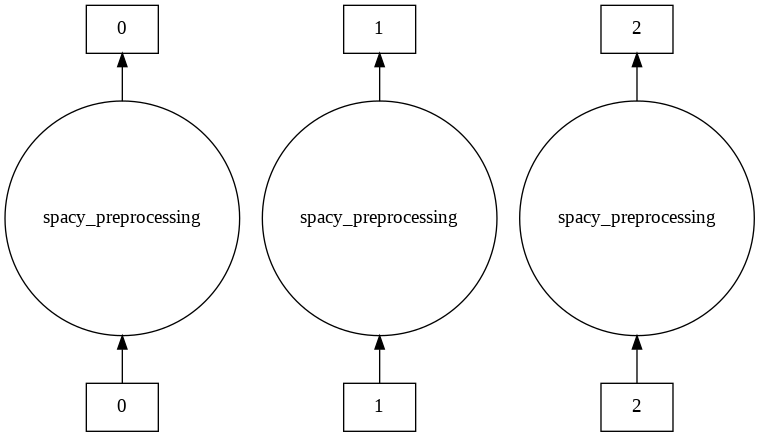

In [17]:
dask.visualize(clean_reviews)

In [18]:
%%time
clean_text = clean_reviews.compute()

CPU times: user 996 ms, sys: 60.4 ms, total: 1.06 s
Wall time: 5.64 s


In [19]:
type(clean_text)

list

In [20]:
#clean_lines_pp,end_time = text_profiling()

## Creating Dataset Object

In [21]:
data2 = data[['clean_lines','airline_sentiment']]
target_map = {'negative': 0,  'positive': 1,'neutral':2}
data2['label'] = data2['airline_sentiment'].map(target_map)

In [22]:
data2=data2[['clean_lines','label']]
data2.columns = ['sentence','label']
data2.to_csv('/content/drive/MyDrive/data/cleaned_tweets_airline.csv',index = None)


In [23]:
!head /content/drive/MyDrive/data/cleaned_tweets_airline.csv

sentence,label
virginamerica what dhepburn said,2
virginamerica plus you ve added commercials to the experience tacky,1
virginamerica didn today must mean need to take another trip,2
virginamerica it really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse,0
virginamerica and it really big bad thing about it,0
virginamerica seriously would pay flight for seats that didn have this playing it really the only bad thing about flying va,0
virginamerica yes nearly every time fly vx this ear worm won go away,1
virginamerica really missed prime opportunity for men without hats parody there,2
virginamerica well didn but now do,1


In [24]:
raw_datasets = load_dataset('csv',data_files='/content/drive/MyDrive/data/cleaned_tweets_airline.csv') 

Using custom data configuration default-4892083fa092b6de


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-4892083fa092b6de/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [26]:
split = raw_datasets['train'].train_test_split(test_size=0.3, seed=42)

In [27]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

## Tokenizing 

In [28]:
from transformers import AutoTokenizer

In [29]:
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

### Tokenization the entire dataset

In [30]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

tokenized_dataset = split.map(tokenize_fn, batched=True)

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [31]:
print(tokenize_fn(raw_datasets['train'][:3]))

{'input_ids': [[101, 6261, 14074, 14735, 2054, 28144, 13699, 8022, 2056, 102], [101, 6261, 14074, 14735, 4606, 2017, 2310, 2794, 12698, 2000, 1996, 3325, 26997, 2100, 102], [101, 6261, 14074, 14735, 2134, 2651, 2442, 2812, 2342, 2000, 2202, 2178, 4440, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [32]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4392
    })
})

In [33]:
tokenized_dataset['test']['label']

[1,
 1,
 2,
 2,
 0,
 0,
 2,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 2,
 2,
 1,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 2,


## Modeling

In [34]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification

In [35]:
from transformers import AutoModelForSequenceClassification
import torch
model_ckpt =  'distilbert-base-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels=3



In [36]:
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

In [37]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0

##Training Arguments


In [38]:
batch_size= 64
logging_steps = len(tokenized_dataset["train"]) // batch_size
model_name = "real_airline_tweet_analysis_model"
training_args = TrainingArguments(
    'airline_tweet_lp_real',
    evaluation_strategy='epoch',
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_strategy='epoch',
    logging_steps=logging_steps,
    log_level="error",
    push_to_hub=False,
    disable_tqdm=False
    )

In [39]:
def compute_metrics(pred):
  labels=pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels,preds, average="weighted"),
  acc = accuracy_score(labels,preds)
  return {"accuracy":acc,"f1":f1}


In [40]:
from transformers import Trainer 
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset = tokenized_dataset['test'],
                  tokenizer=tokenizer)

In [41]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.647500,0.485932,0.811931,"(0.8061172516567534,)"
2,0.433300,0.461665,0.817395,"(0.8142345291212538,)"


TrainOutput(global_step=322, training_loss=0.5393139397875862, metrics={'train_runtime': 52.0308, 'train_samples_per_second': 393.921, 'train_steps_per_second': 6.189, 'total_flos': 187964241692976.0, 'train_loss': 0.5393139397875862, 'epoch': 2.0})

In [42]:
tokenized_dataset['train']['input_ids'][0:3]

[[101,
  3915,
  4313,
  14035,
  2435,
  2039,
  2044,
  2062,
  2084,
  2847,
  2006,
  2907,
  2145,
  2342,
  2008,
  24306,
  2197,
  2051,
  2009,
  2001,
  5763,
  2009,
  2196,
  3369,
  2393,
  102],
 [101,
  6892,
  16558,
  5657,
  2022,
  3909,
  2574,
  2000,
  16392,
  2006,
  2115,
  8582,
  1997,
  2035,
  7608,
  2310,
  10583,
  2017,
  2128,
  2145,
  2000,
  2033,
  102],
 [101,
  2142,
  1047,
  2266,
  3714,
  2835,
  2067,
  3714,
  2694,
  3714,
  2422,
  2439,
  4524,
  20277,
  16215,
  26807,
  25423,
  12476,
  3105,
  102]]